<a href="https://colab.research.google.com/github/MachokaGit/Python-Notebooks/blob/master/Prophet_%2B_chatGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV files
train_df = pd.read_csv('DailyDelhiClimateTrain.csv')
test_df = pd.read_csv('DailyDelhiClimateTest.csv')

# Combine the two dataframes
combined_df = pd.concat([train_df, test_df])

# Sorting the DataFrame by the date column in descending order and setting date as index
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df.sort_values(by='date', ascending=True, inplace=True)
combined_df.set_index('date', inplace=True)

# Summary of the DataFrame
print(combined_df.info())




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1576 entries, 2013-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1576 non-null   float64
 1   humidity      1576 non-null   float64
 2   wind_speed    1576 non-null   float64
 3   meanpressure  1576 non-null   float64
dtypes: float64(4)
memory usage: 61.6 KB
None


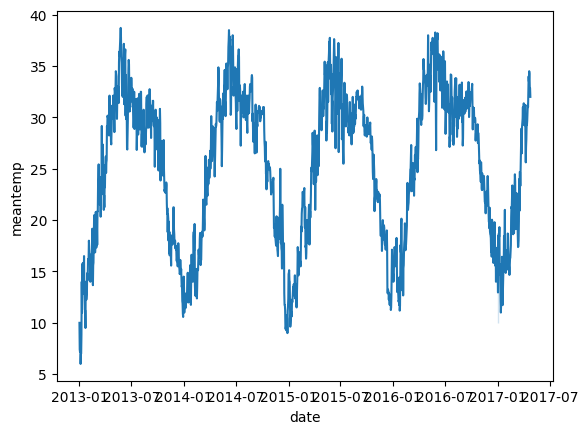

In [ ]:
# Plotting the target variable
sns.lineplot(data=combined_df, x=combined_df.index, y='meantemp')
plt.show()

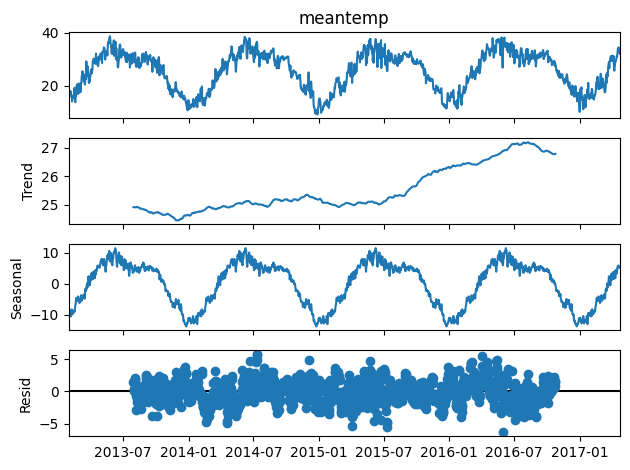

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Handling nulls and imputing values
combined_df.interpolate(method='linear', inplace=True)

# Creating lag features
for lag in [7, 14, 21, 28]:
    combined_df[f'lag_{lag}'] = combined_df['meantemp'].shift(lag)

# Dropping rows with NaN values created due to lagging
combined_df.dropna(inplace=True)

# Seasonal decomposition of the target variable
decomposition = seasonal_decompose(combined_df['meantemp'], period=365)
decomposition.plot()
plt.show()




In [ ]:
# Display the top 5 rows of the DataFrame
print(combined_df.head())

             meantemp   humidity  wind_speed  meanpressure      lag_7  \
date                                                                    
2013-01-29  14.125000  65.500000    3.237500   1016.625000   9.500000   
2013-01-30  14.714286  70.428571    1.057143   1017.857143  14.000000   
2013-01-31  16.200000  65.600000    2.960000   1018.400000  13.833333   
2013-02-01  16.000000  73.000000    2.220000   1016.000000  12.250000   
2013-02-02  16.285714  77.571429    1.328571   1017.142857  12.666667   

               lag_14     lag_21     lag_28  
date                                         
2013-01-29  14.714286   8.857143  10.000000  
2013-01-30  13.833333  14.000000   7.400000  
2013-01-31  16.500000  11.000000   7.166667  
2013-02-01  13.833333  15.714286   8.666667  
2013-02-02  12.500000  14.000000   6.000000  


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpygufiysm/t14aqr2w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpygufiysm/wv6w64vg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30784', 'data', 'file=/tmp/tmpygufiysm/t14aqr2w.json', 'init=/tmp/tmpygufiysm/wv6w64vg.json', 'output', 'file=/tmp/tmpygufiysm/prophet_modelmj0zic_t/prophet_model-20240126220257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:02:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:02:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


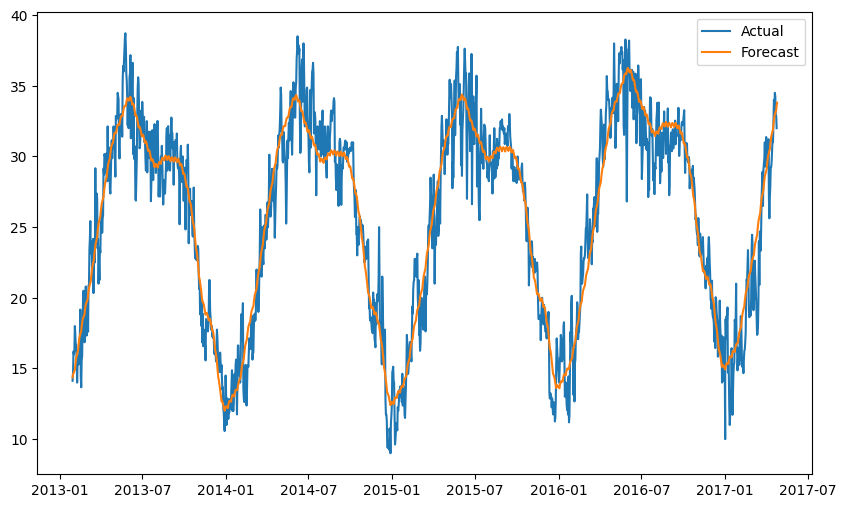

In [ ]:
from prophet import Prophet

# Preparing data for Prophet
prophet_df = combined_df.reset_index()[['date', 'meantemp']].rename(columns={'date': 'ds', 'meantemp': 'y'})

# Splitting data into train and test
train_prophet_df = prophet_df[prophet_df['ds'] < test_df['date'].min()]
test_prophet_df = prophet_df[prophet_df['ds'] >= test_df['date'].min()]

# Training the model
model = Prophet()
model.fit(train_prophet_df)

# Making predictions
future = model.make_future_dataframe(periods=len(test_prophet_df))
forecast = model.predict(future)

# Making predictions for the next 20 years
future_extended = model.make_future_dataframe(periods=20*365)
forecast_extended = model.predict(future_extended)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.legend()
plt.show()


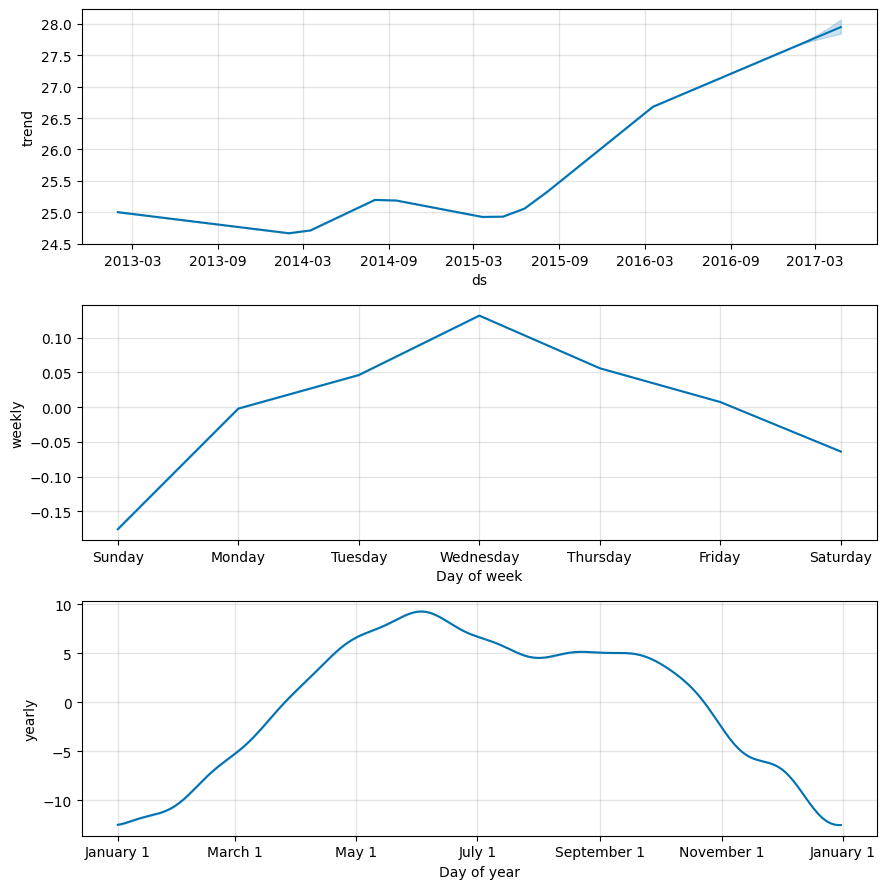

In [ ]:
fig = model.plot_components(forecast)
plt.show()


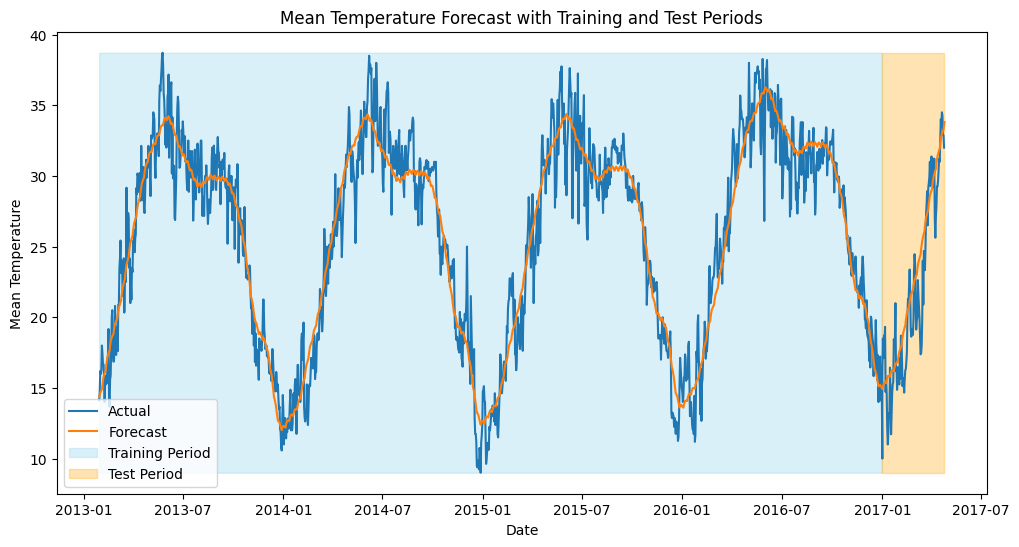

In [ ]:
import matplotlib.dates as mdates

# Enhanced Visualization with Shading
plt.figure(figsize=(12, 6))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')

# Adding shading for training and test periods
train_period = mdates.date2num(train_prophet_df['ds'])
test_period = mdates.date2num(test_prophet_df['ds'])

plt.fill_between(train_period, min(prophet_df['y']), max(prophet_df['y']), color='skyblue', alpha=0.3, label='Training Period')
plt.fill_between(test_period, min(prophet_df['y']), max(prophet_df['y']), color='orange', alpha=0.3, label='Test Period')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Forecast with Training and Test Periods')
plt.show()


In [ ]:
from prophet import Prophet

# Preparing data for Prophet
prophet_df = combined_df.reset_index()[['date', 'meantemp']].rename(columns={'date': 'ds', 'meantemp': 'y'})

# Splitting data into train and test
train_prophet_df = prophet_df[prophet_df['ds'] < test_df['date'].min()]
test_prophet_df = prophet_df[prophet_df['ds'] >= test_df['date'].min()]

# Training the model
model = Prophet()
model.fit(train_prophet_df)

# Making predictions for the next 20 years
future_extended = model.make_future_dataframe(periods=5*365)
forecast_extended = model.predict(future_extended)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpygufiysm/0yvx01_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpygufiysm/crsmowwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=607', 'data', 'file=/tmp/tmpygufiysm/0yvx01_r.json', 'init=/tmp/tmpygufiysm/crsmowwb.json', 'output', 'file=/tmp/tmpygufiysm/prophet_modelcwrrh6tl/prophet_model-20240126221305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


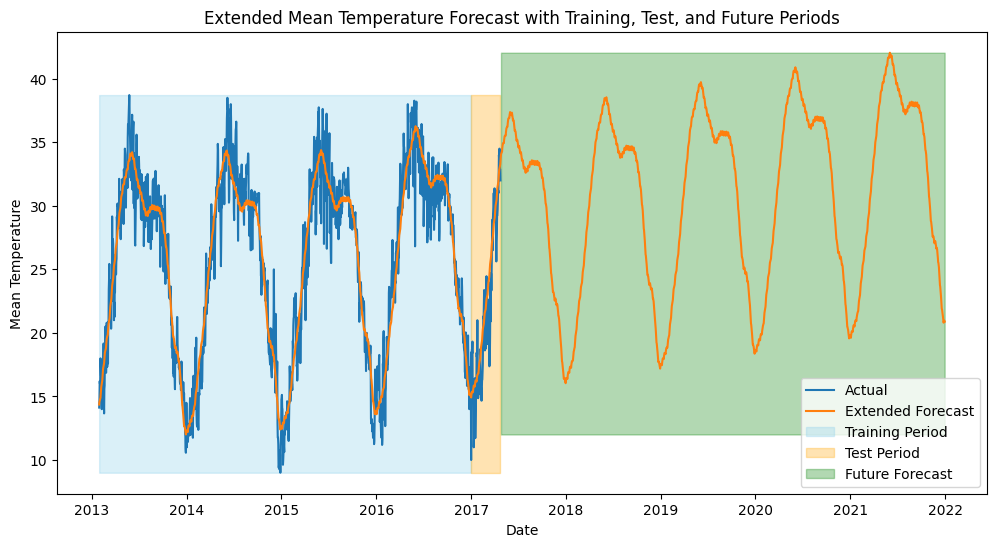

In [ ]:
import matplotlib.dates as mdates

# Enhanced Visualization with Shading for Extended Forecast
plt.figure(figsize=(12, 6))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual')
plt.plot(forecast_extended['ds'], forecast_extended['yhat'], label='Extended Forecast')

# Adding shading for training, test, and future forecast periods
train_period = mdates.date2num(train_prophet_df['ds'])
test_period = mdates.date2num(test_prophet_df['ds'])
future_period = mdates.date2num(forecast_extended['ds'][len(prophet_df['ds']):])

plt.fill_between(train_period, min(prophet_df['y']), max(prophet_df['y']), color='skyblue', alpha=0.3, label='Training Period')
plt.fill_between(test_period, min(prophet_df['y']), max(prophet_df['y']), color='orange', alpha=0.3, label='Test Period')
plt.fill_between(future_period, min(forecast_extended['yhat']), max(forecast_extended['yhat']), color='green', alpha=0.3, label='Future Forecast')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Extended Mean Temperature Forecast with Training, Test, and Future Periods')
plt.show()


In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics

# Parameters for cross-validation
initial = '730 days'  # Initial 3 years for training
period = '365 days'    # Roll forward by 1 year
horizon = '365 days'   # Forecast 1 year

# Conduct cross-validation
df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon)

# Calculate performance metrics
df_performance = performance_metrics(df_cv)
print(df_performance)


INFO:prophet:Making 1 forecasts with cutoffs between 2016-01-01 00:00:00 and 2016-01-01 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpygufiysm/ruhml34k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpygufiysm/431npnab.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34613', 'data', 'file=/tmp/tmpygufiysm/ruhml34k.json', 'init=/tmp/tmpygufiysm/431npnab.json', 'output', 'file=/tmp/tmpygufiysm/prophet_modeljs8vrost/prophet_model-20240126222034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:20:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:20:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


     horizon        mse      rmse       mae      mape     mdape     smape  \
0    36 days   8.033331  2.834313  2.369829  0.151984  0.166753  0.161951   
1    37 days   7.937376  2.817335  2.318277  0.148301  0.166753  0.158006   
2    38 days   7.815494  2.795620  2.281676  0.145446  0.165903  0.154806   
3    39 days   7.567901  2.750982  2.230775  0.141911  0.158114  0.150673   
4    40 days   7.330920  2.707567  2.183605  0.138561  0.150471  0.146746   
..       ...        ...       ...       ...       ...       ...       ...   
325 361 days  10.336517  3.215045  2.805521  0.145300  0.153677  0.160642   
326 362 days  10.641365  3.262110  2.843618  0.148782  0.157058  0.164993   
327 363 days  10.533998  3.245612  2.826935  0.149819  0.163925  0.166236   
328 364 days  10.487912  3.238505  2.815936  0.150585  0.163925  0.167102   
329 365 days  10.137109  3.183883  2.769146  0.150544  0.163925  0.167053   

     coverage  
0    0.527778  
1    0.527778  
2    0.555556  
3    0.5833

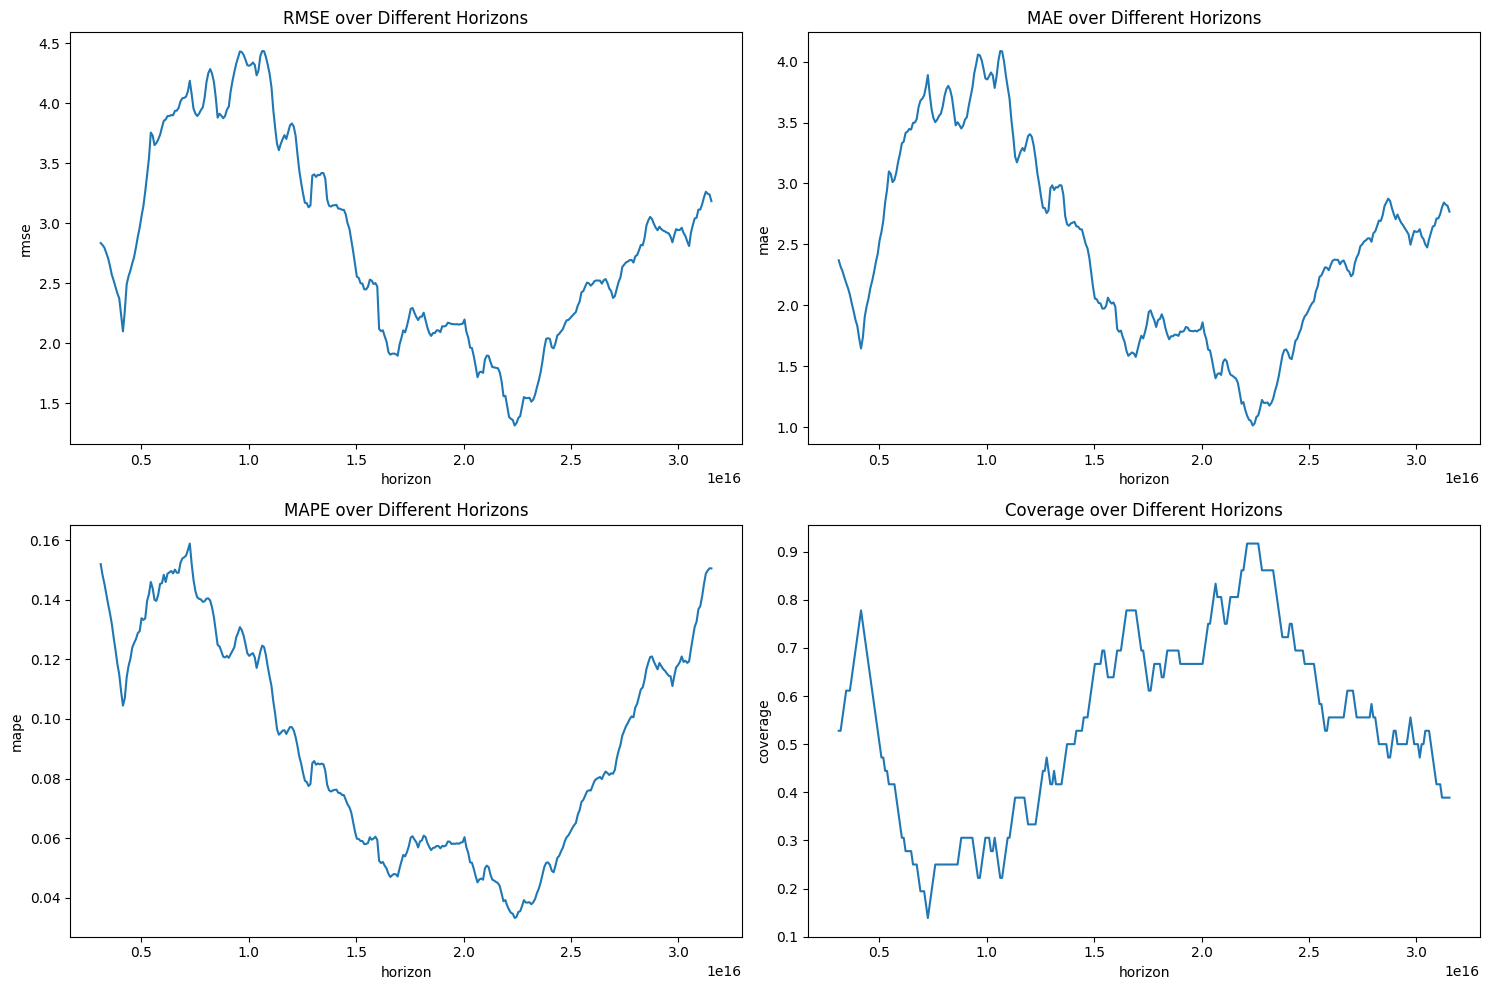

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'horizon' from string to timedelta for plotting
df_performance['horizon'] = pd.to_timedelta(df_performance['horizon'])

# Setting up the matplotlib figure
plt.figure(figsize=(15, 10))

# Subplot 1: RMSE
plt.subplot(2, 2, 1)
sns.lineplot(data=df_performance, x='horizon', y='rmse')
plt.title('RMSE over Different Horizons')

# Subplot 2: MAE
plt.subplot(2, 2, 2)
sns.lineplot(data=df_performance, x='horizon', y='mae')
plt.title('MAE over Different Horizons')

# Subplot 3: MAPE
plt.subplot(2, 2, 3)
sns.lineplot(data=df_performance, x='horizon', y='mape')
plt.title('MAPE over Different Horizons')

# Subplot 4: Coverage
plt.subplot(2, 2, 4)
sns.lineplot(data=df_performance, x='horizon', y='coverage')
plt.title('Coverage over Different Horizons')

plt.tight_layout()
plt.show()
